In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
BATCH_SIZE = 32
IMAGE_LENGTH = 256
IMAGE_BREADTH = 256
CHANNELS = 3
EPOCHS = 40

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../DataSet/Pepper_Bell',
    batch_size = BATCH_SIZE,
    shuffle = True,
    image_size = (IMAGE_LENGTH, IMAGE_BREADTH)
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [5]:
TRAIN_FRACTION = 0.8
VALIDATE_FRACTION = 0.1
TEST_FRACTION = 0.1

ds_size = len(dataset)
train_size = int(len(dataset)*TRAIN_FRACTION)
val_size = int(len(dataset)*VALIDATE_FRACTION)
test_size = int(len(dataset)*TEST_FRACTION)

train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size).skip(val_size)
ds_size = [len(train), len(val), len(test)]
ds_size

[62, 7, 9]

In [6]:
train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
adjust = tf.keras.Sequential([
    keras.layers.Rescaling(1.0/255),
    keras.layers.Resizing(IMAGE_LENGTH, IMAGE_BREADTH)
])

augment = tf.keras.Sequential([
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(0.2)
])


In [9]:
input_dimensions = (BATCH_SIZE, IMAGE_LENGTH, IMAGE_BREADTH, CHANNELS)


model = keras.models.Sequential([
    adjust,
    augment,
    
    keras.layers.Conv2D(32, (3, 3), input_shape = input_dimensions, activation = 'relu'),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPool2D(2, 2),
    
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPool2D(2, 2),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax')

])

model.build(input_shape = input_dimensions)

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [11]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [12]:
# with tf.device('/GPU:0'):
history = model.fit(
    train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val
)

Epoch 1/40
62/62 [==============================] - 40s 379ms/step - loss: 0.6283 - accuracy: 0.6850 - val_loss: 0.5211 - val_accuracy: 0.7768
Epoch 2/40
62/62 [==============================] - 13s 202ms/step - loss: 0.2676 - accuracy: 0.9012 - val_loss: 0.5364 - val_accuracy: 0.9554
Epoch 3/40
62/62 [==============================] - 13s 207ms/step - loss: 0.1183 - accuracy: 0.9617 - val_loss: 0.7502 - val_accuracy: 0.9643
Epoch 4/40
62/62 [==============================] - 13s 208ms/step - loss: 0.0600 - accuracy: 0.9829 - val_loss: 0.4237 - val_accuracy: 0.9866
Epoch 5/40
62/62 [==============================] - 13s 212ms/step - loss: 0.0787 - accuracy: 0.9798 - val_loss: 0.3230 - val_accuracy: 0.9866
Epoch 6/40
62/62 [==============================] - 13s 213ms/step - loss: 0.0296 - accuracy: 0.9924 - val_loss: 0.2662 - val_accuracy: 0.9866
Epoch 7/40
62/62 [==============================] - 13s 215ms/step - loss: 0.0225 - accuracy: 0.9940 - val_loss: 0.3810 - val_accuracy: 0.9821

In [13]:
model.evaluate(test)

9/9 [==============================] - 7s 120ms/step - loss: 0.0015 - accuracy: 1.0000


[0.0015220270724967122, 1.0]

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

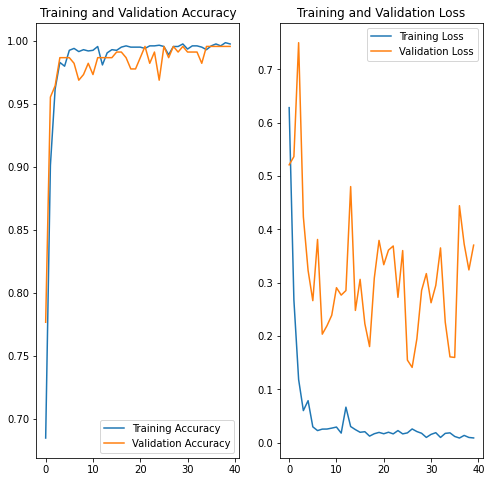

In [15]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

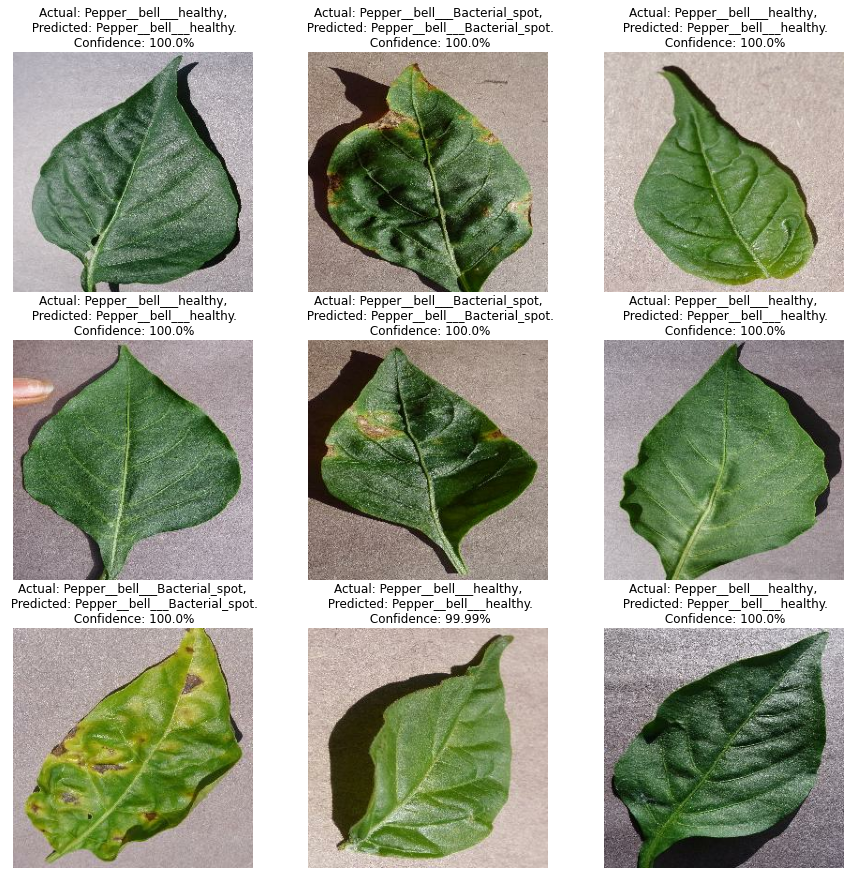

In [17]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [18]:
model_version = 1
model_name = f'pepper_bell_{model_version}'
model.save(f"../saved_models/{model_name}")

INFO:tensorflow:Assets written to: ../saved_models/pepper_bell_1\assets
